In [6]:
import math
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

import tensorflow.contrib.learn as skflow
# from tensorflow import estimator
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.data import Dataset

from sklearn import metrics
from sklearn.model_selection import train_test_split

from datetime import datetime

import logging
logging.basicConfig(level=logging.INFO)
logging.info('Tensorflow %s' % tf.__version__) # 1.4.1

INFO:root:Tensorflow 1.12.0


In [4]:
def linear_scale(series):
    """Applies min-max scaling to each value in the series"""
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def log_normalize(series):
    """Shifts each value in the series by 1.0 then log transforms"""
    return series.apply(lambda x:math.log(x+1.0))

def inv_log_normalize(series):
    """Exponentiates log transformed values then shifts by -1.0"""
    return series.apply(lambda x: math.exp(x)-1.0)

def normalize(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    processed_features = pd.DataFrame()
    for column in examples_dataframe.columns:
        if "windSpeed" or "Size" in column:
            processed_features[column] = log_normalize(examples_dataframe[column]).astype('float32')
        else:
            processed_features[column] = linear_scale(examples_dataframe[column]).astype('float32')
    return processed_features

In [5]:
def ignitionIndex(column_name):
    """Extracts the hour relative to fire ignition from a column name
    e.g.
    temperature_14 -> 14
    """
    return int(column_name
               .replace("summary", "")
               .replace("precipType", "")
               .replace("temperature", "")
               .replace("apparentTemperature", "")
               .replace("dewPoint", "")
               .replace("humidity", "")
               .replace("pressure", "")
               .replace("windSpeed", "")
               .replace("windGust", "")
               .replace("windBearing", "")
               .replace("cloudCover", "")
               .replace("uvIndex", "")
               .replace("visibility", "")
               .replace("precipIntensity", "")
               .replace("precipProbability", "")
               .replace("_", ""))

def hasNumbers(string):
    """Determines if a string has an integers"""
    return any(char.isdigit() for char in string)

In [32]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature)
                  for my_feature in input_features.columns])

In [33]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.

    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
          shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}

    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))  # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [1]:
def preprocess_data(wildfire_dataframe):
    """Prepares input features from California wildfire data
    df: A Pandas DataFrame expected to contain data
      from the training.training wildfire collection.
      Returns:
        A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    """Prepares target features (i.e., labels) from the wildfire data set.
    Args: 
        wildfire_dataframe: A Pandas DataFrame expected to contain data
        from the training.training wildfire collection.
    Returns:
       A DataFrame that contains the target feature.
    """
    df = wildfire_dataframe.copy()
    
    # use only temperature, wind speed, and humidity as model inputs
    descriptive_features = ["temperature", "windSpeed", "humidity"]
    
    # want to predict fire size
    target_features = ["Size"]
    all_features = descriptive_features+target_features

    # get rid of columns not in all_features and restrict only daily data
    c1 = lambda col: not hasNumbers(col) # 
    c2 = lambda col: (hasNumbers(col) and ignitionIndex(col) % 24 == 0) # daily data points
    c3 = lambda col: any(map(lambda k: k in col, all_features)) # 
    
    cols = filter(lambda col: (c1(col) or c2(col)) and c3(col), [col for col in df.columns])
    df = df[cols]
    
    # remove all rows containing a NaN in any feature
    df = df.dropna()
    
    
    all_targets = df[["Size"]].copy()
    
    # create an 80/10/10 train/validation/test split
    training_percent = .80
    training_length = math.floor(len(df.index) * training_percent)
    rest_size = len(df[training_length:].index)
    
    
    # construct training, validation, and test datasets
    training_df = df.copy()[0:training_length]
    validation_df = df.copy()[training_length:training_length+math.floor(rest_size/2)]
    test_df = df.copy()[training_length+math.floor(rest_size/2):]
    
    def process_df(training_df):
        features = training_df.drop(columns=target_features)
        targets = training_df[target_features]
        return features, targets
    
    training_features, training_targets = process_df(training_df)    
    validation_features, validation_targets = process_df(validation_df)
    test_features, test_targets = process_df(test_df)
    
    return training_features,\
            training_targets,\
            validation_features,\
            validation_targets,\
            test_features,\
            test_targets, \
            all_targets

In [65]:
# Load data split from previous run


# X_train = pd.read_csv('.\\data\\'+'run_2'+'\\X_train.csv').astype("float32")
# y_train = pd.read_csv('.\\data\\'+'run_2'+'\\y_train.csv').astype("float32")
# X_valid = pd.read_csv('.\\data\\'+'run_2'+'\\X_valid.csv').astype("float32")
# y_valid = pd.read_csv('.\\data\\'+'run_2'+'\\y_valid.csv').astype("float32")
# X_test = pd.read_csv('.\\data\\'+'run_2'+'\\X_test.csv').astype("float32")
# y_test = pd.read_csv('.\\data\\'+'run_2'+'\\y_test.csv').astype("float32")


# y_all = pd.concat([y_train, y_valid, y_test])
# print(y_all.describe())

# # contains train, valid, test
# y_all.to_csv('.\\data\\'+RUN_NAME+'\\y_all.csv')

        Unnamed: 0           Size
count  1825.000000    1825.000000
mean    978.908508    5155.933105
std     545.721436   23132.806641
min       0.000000       0.100000
25%     514.000000      58.000000
50%     990.000000     255.000000
75%    1450.000000    1223.000000
max    1910.000000  410203.000000


Training targets summary:
              Size
count   995.000000
mean    606.615176
std     948.760629
min       0.100000
25%      50.000000
50%     190.000000
75%     766.500000
max    5738.000000
Validation targets summary:
              Size
count   332.000000
mean    673.378614
std    1132.110363
min       1.000000
25%      45.925000
50%     200.000000
75%     708.250000
max    5514.000000
Test targets summary:
              Size
count   332.000000
mean    641.254639
std    1152.739541
min       1.000000
25%      40.000000
50%     160.000000
75%     541.000000
max    5731.000000
All fire targets summary:
              Size
count  1659.000000
mean    626.907981
std    1030.303963
min       0.100000
25%      50.000000
50%     189.000000
75%     708.000000
max    5738.000000


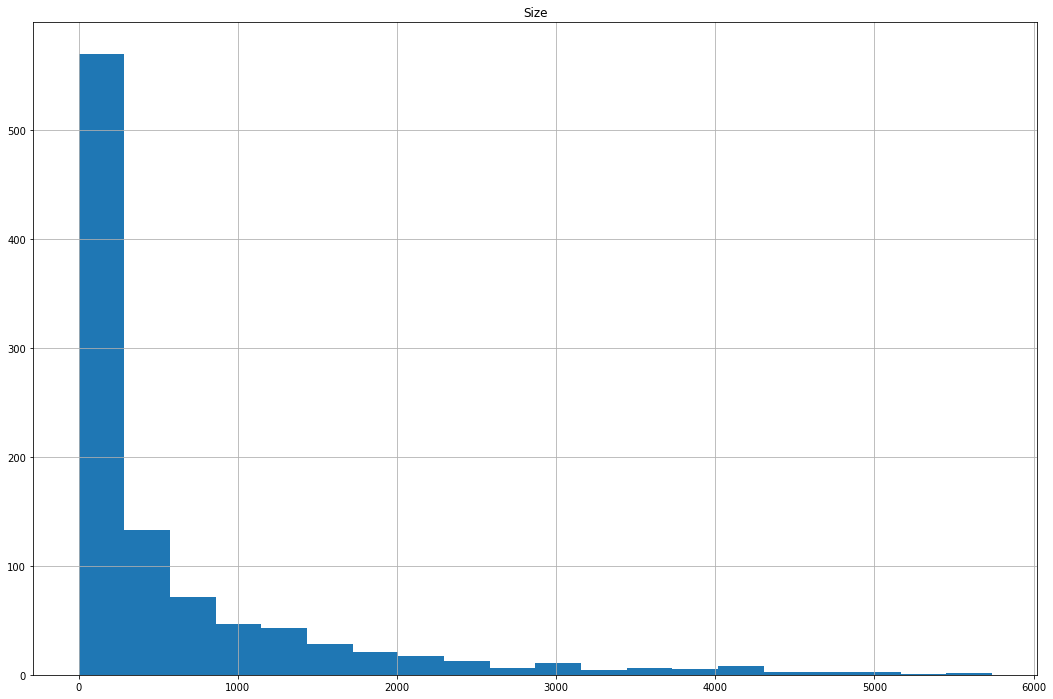

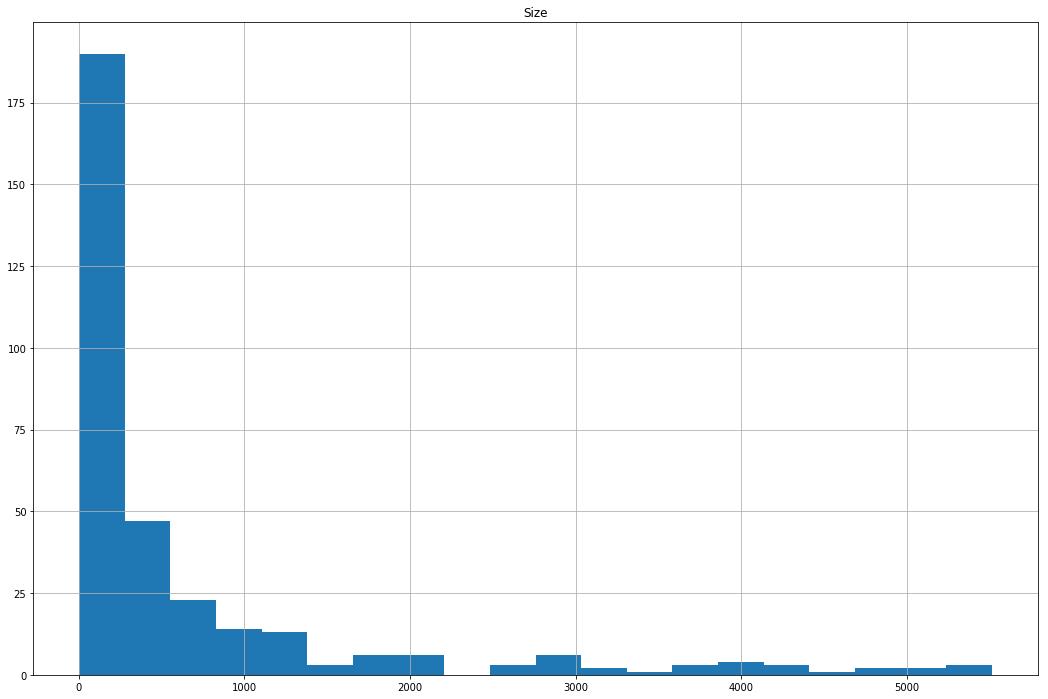

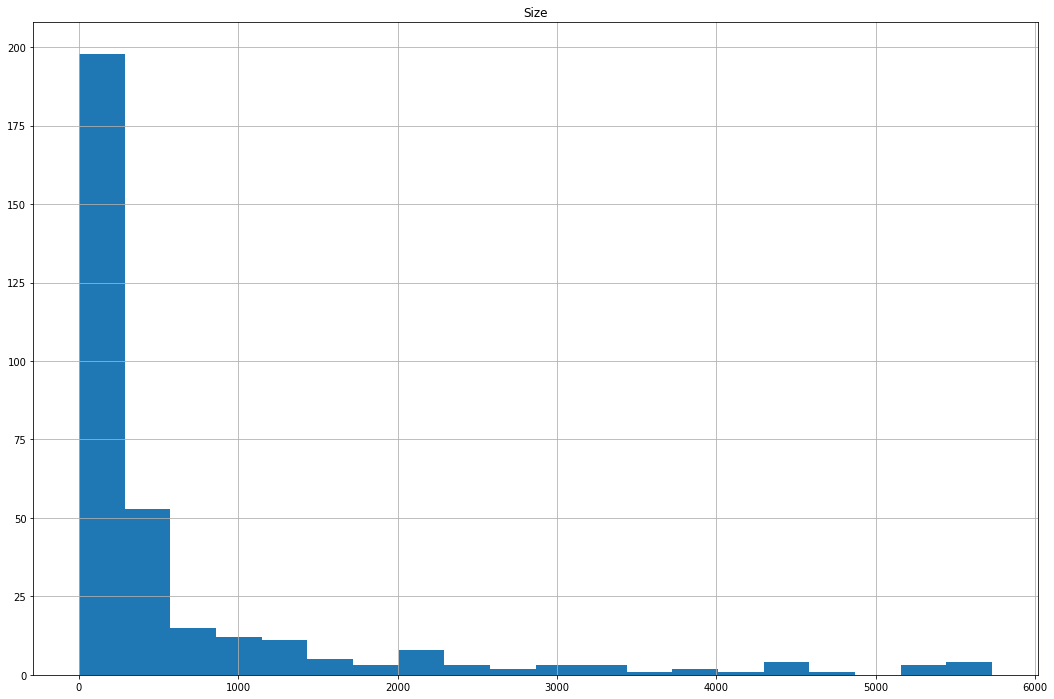

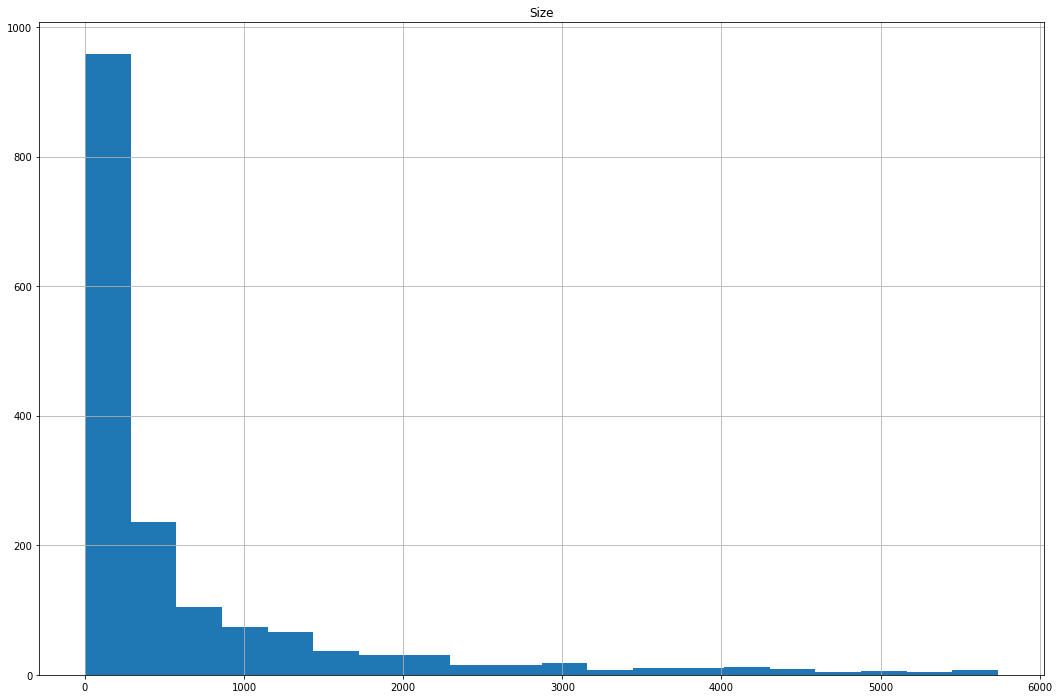

In [16]:
# load the data
csv_path = r".\\data\\wildfire_events_full.csv"
df = pd.read_csv(csv_path)

# shuffle the data to prevent bias
df = df.reindex(np.random.permutation(df.index))

# construct training and validation examples
X_train,y_train,X_valid,y_valid,X_test,y_test, y_all = preprocess_data(df)

# set current date and time as run name
RUN_NAME = datetime.now().strftime("%Y%m%d_%H%M%S")

# export data splits to csv
X_train.to_csv('.\\data\\'+RUN_NAME+'\\X_train.csv')
y_train.to_csv('.\\data\\'+RUN_NAME+'\\y_train.csv')
X_valid.to_csv('.\\data\\'+RUN_NAME+'\\X_valid.csv')
y_valid.to_csv('.\\data\\'+RUN_NAME+'\\y_valid.csv')
X_test.to_csv('.\\data\\'+RUN_NAME+'\\X_test.csv')
y_test.to_csv('.\\data\\'+RUN_NAME+'\\y_test.csv')
y_all.to_csv('.\\data\\'+RUN_NAME+'\\y_all.csv')

# plot distribution of target feature for each data split
y_train_hist = y_train.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\y_train_hist.png')
y_valid_hist = y_valid.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\y_valid_hist.png')
y_test_hist = y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\y_test_hist.png')
y_all_hist = y_all.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\y_all_hist.png')

# summarize distribution of target feature for each data split
print("Training targets summary:")
print(y_train.describe())
print("Validation targets summary:")
print(y_valid.describe())
print("Test targets summary:")
print(y_test.describe())
print("All fire targets summary:")
print(y_all.describe())

In [52]:
# Load data splits from previous run

# norm_X_train = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_train.csv', index_col=0).astype("float32")
# norm_y_train = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_train.csv', index_col=0).astype("float32")


# norm_X_valid = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_valid.csv', index_col=0).astype("float32")
# norm_y_valid = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_valid.csv', index_col=0).astype("float32")

# norm_X_test = pd.read_csv('.\\data\\'+'run_2'+'\\norm_X_test.csv', index_col=0).astype("float32")
# norm_y_test = pd.read_csv('.\\data\\'+'run_2'+'\\norm_y_test.csv', index_col=0).astype("float32")

# print(norm_X_train.describe())
# print(norm_X_valid.describe())
# print(norm_X_test.describe())



       temperature_336  humidity_336  windSpeed_336  temperature_312  \
count      1460.000000   1460.000000    1460.000000      1460.000000   
mean          4.115416      0.444438       0.847381         4.117058   
std           0.162759      0.140091       0.542354         0.159912   
min           3.358985      0.058269       0.000000         3.318178   
25%           4.024816      0.329304       0.431782         4.025664   
50%           4.130194      0.438255       0.741937         4.128424   
75%           4.228475      0.565314       1.193923         4.228329   
max           4.579853      0.693147       3.044046         4.580673   

       humidity_312  windSpeed_312  temperature_288  humidity_288  \
count   1460.000000    1460.000000      1460.000000   1460.000000   
mean       0.443653       0.819778         4.121139      0.441704   
std        0.135502       0.537808         0.158303      0.133162   
min        0.086178       0.000000         3.392829      0.095310   
25%   

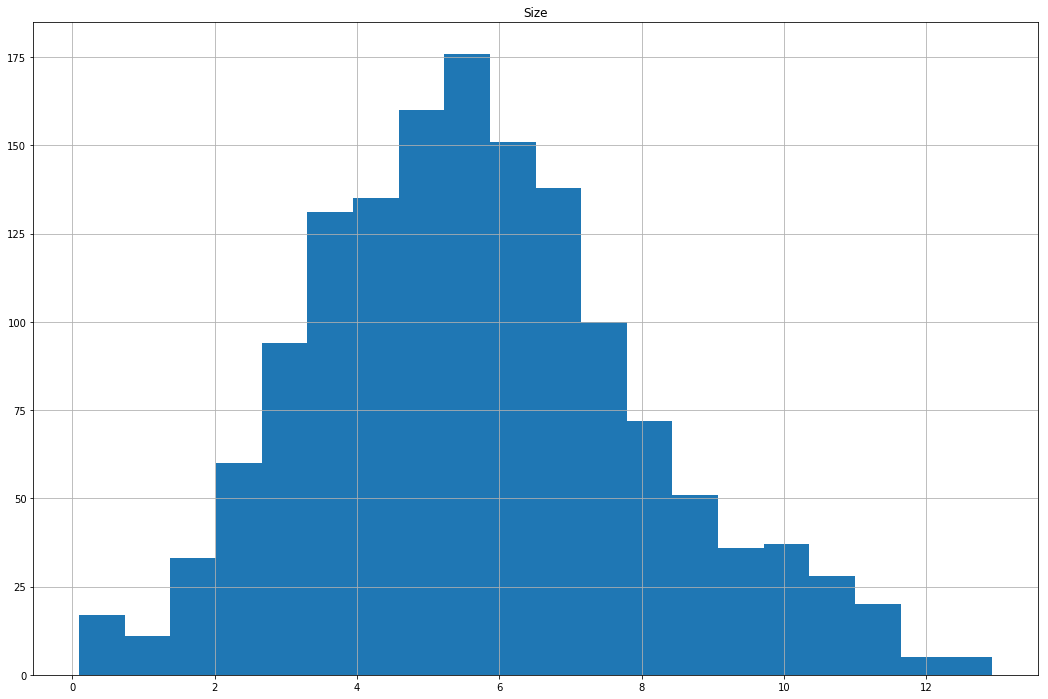

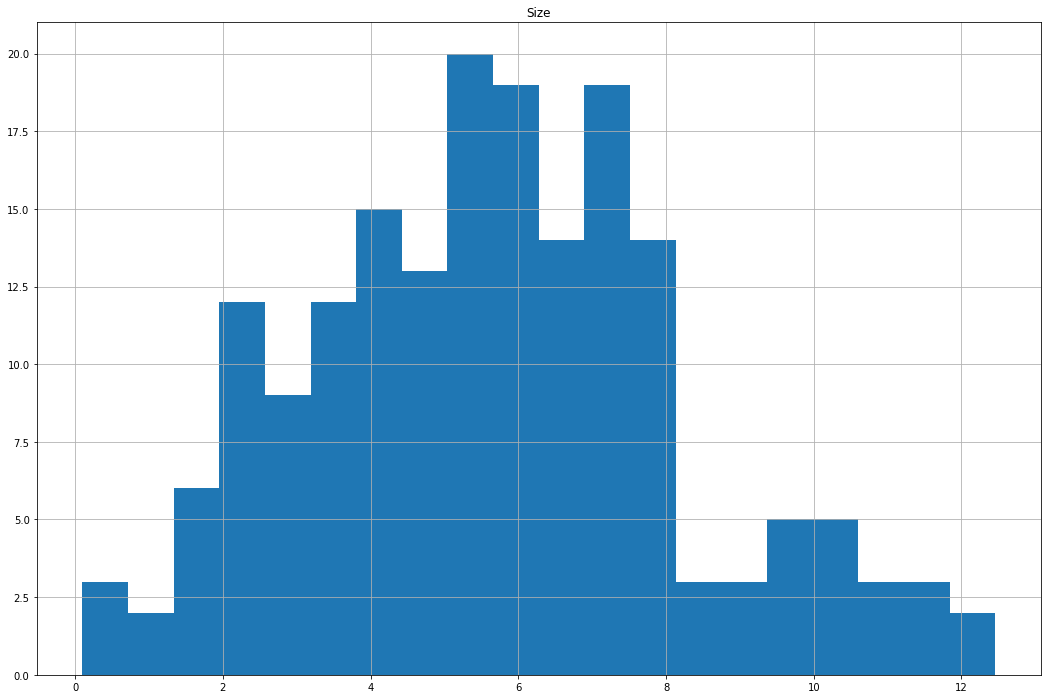

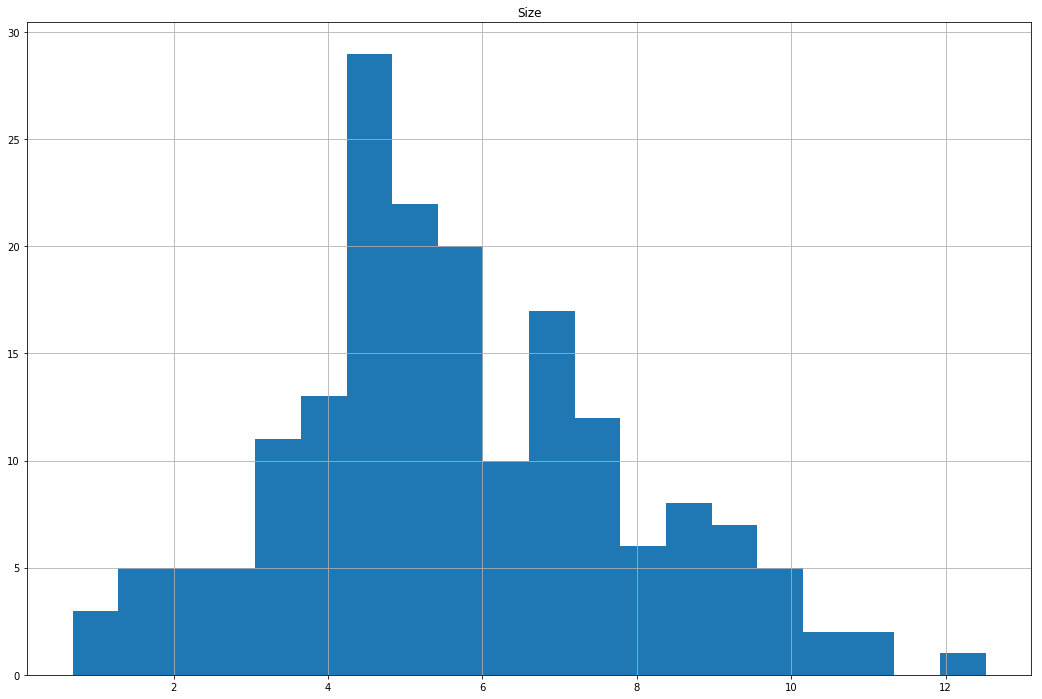

In [53]:
# normalize the descriptive and target features across each data split
norm_X_train = normalize(X_train)
norm_X_valid = normalize(X_valid)
norm_X_test = normalize(X_test)
norm_y_train = normalize(y_train)
norm_y_valid = normalize(y_valid)
norm_y_test = normalize(y_test)

# export normalized data splits to csv
norm_X_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_train.csv')
norm_y_train.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_train.csv')
norm_X_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_valid.csv')
norm_y_valid.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_valid.csv')
norm_X_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_X_test.csv')
norm_y_test.to_csv('.\\data\\'+RUN_NAME+'\\norm_y_test.csv')

# plot distribution of normalized target feature for each data split
norm_y_train_hist = norm_y_train.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_train_hist.png')
norm_y_valid_hist = norm_y_valid.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_valid_hist.png')
norm_y_test_hist = norm_y_test.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.savefig('.\\data\\'+RUN_NAME+'\\norm_y_test_hist.png')

# # summarize distribution of normalized descriptive features for each data split
# print("Training descriptive features summary:")
# print(norm_X_train.describe())
# print("Validation descriptive features summary:")
# print(norm_X_valid.describe())
# print("Test descriptive features summary:")
# print(norm_X_test.describe())

# summarize distribution of normalized target feature for each data split
print("Training targets summary:")
print(y_train.describe())
print("Validation targets summary:")
print(y_valid.describe())
print("Test targets summary:")
print(y_test.describe())
print("All fire targets summary:")
print(y_all.describe())


In [37]:
# n = 5
# norm_X_train = norm_X_train.head(n)
# norm_y_train = norm_y_train.head(n)
# norm_X_valid = norm_X_valid.head(n)
# norm_y_valid = norm_y_valid.head(n)

# define the tf input functions for training
def training_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_train, 
                                      norm_y_train["Size"], 
                                      batch_size=batch_size)

def validation_input_fn(batch_size=1):
    return lambda: my_input_fn(norm_X_valid, 
                                            norm_y_valid["Size"], 
                                            num_epochs=1, 
                                            shuffle=False)



In [66]:
# get tf descriptive features
feature_columns = construct_feature_columns(norm_X_train)

# set learning parameters
STEPS_PER_EPOCH = 100
EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 0.001

# set network architecture
neuron_split = 2**0
num_neurons = math.floor(len(norm_X_train.columns)/neuron_split)
num_layers = 1
hidden_layers = []

# add hidden layers to network
for i in range(num_layers):
    hidden_layers.append(num_neurons)
print(hidden_layers)

# set dropout probability
dropout = 0.5


MODEL_PATH='./models/DNNRegressors/'+RUN_NAME+'/'

run_str = ""
for hl in hidden_layers:
	run_str += '%s_' % hl
run_str += 'D0%s' % (int(dropout*10))
MODEL_PATH += run_str
logging.info('Saving to %s' % MODEL_PATH)

# validation and test configuration
validation_metrics = {"RMSE": tf.contrib.metrics.streaming_root_mean_squared_error}
test_config = skflow.RunConfig(save_checkpoints_steps=100, save_checkpoints_secs=None)

# create the optimizer
my_optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# build the network
regressor = skflow.DNNRegressor(feature_columns=feature_columns,
# regressor = estimator.DNNRegressor(feature_columns=feature_columns,
				label_dimension=1,
                optimizer=my_optimizer,
				hidden_units=hidden_layers,
				model_dir=MODEL_PATH,
				dropout=dropout,
				config=test_config)


INFO:root:Saving to ./models/DNNRegressors/run_8/87_D05


1
[87]


In [67]:
TRAINING = True
WITHPLOT = False

# Train it
if TRAINING:
	logging.info('Train the DNN Regressor...\n')
	MSEs = []	# for plotting
	STEPS = []	# for plotting

	for epoch in range(EPOCHS+1):

		# Fit the DNNRegressor (This is where the magic happens!!!)
		regressor.fit(input_fn=training_input_fn(batch_size=BATCH_SIZE),
				steps=STEPS_PER_EPOCH)
		# Thats it -----------------------------
		# Start Tensorboard in Terminal:
		# 	tensorboard --logdir='./models/DNNRegressors/'
		# Now open Browser and visit localhost:6006\

		
		# This is just for fun and educational purpose:
		# Evaluate the DNNRegressor every 10th epoch
		if epoch%10==0:
			eval_dict = regressor.evaluate(input_fn=validation_input_fn(),
							metrics=validation_metrics)
# 			print(eval_dict)
			print('Epoch %i: %.5f RMSE' % (epoch+1, eval_dict['RMSE']))


			if WITHPLOT:
				# Generate a plot for this epoch to see the network learning
				y_pred = regressor.predict(x={'X': X}, as_iterable=False)

				E = (y.reshape((1,-1))-y_pred)
				MSE = np.mean(E**2.0)
				step = (epoch+1) * STEPS_PER_EPOCH
				title_string = '%s DNNRegressor after %06d steps (MSE=%.5f)' % \
								(MODEL_PATH.split('/')[-1], step, MSE)
				
				MSEs.append(MSE)
				STEPS.append(step)

				fig = plt.figure(figsize=(9,4))
				ax1 = fig.add_subplot(1, 4, (1, 3))
				ax1.plot(X, y, label='function to predict')
				ax1.plot(X, y_pred, label='DNNRegressor prediction')
				ax1.legend(loc=2)
				ax1.set_title(title_string)
				ax1.set_ylim([0, 1])

				ax2 = fig.add_subplot(1, 4, 4)
				ax2.plot(STEPS, MSEs)
				ax2.set_xlabel('Step')
				ax2.set_xlim([0, EPOCHS*STEPS_PER_EPOCH])
				ax2.set_ylabel('Mean Square Error')
				ax2.set_ylim([0, 0.01])

				plt.tight_layout()
				plt.savefig(MODEL_PATH + '_%05d.png' % (epoch+1), dpi=72)
				logging.info('Saved %s' % MODEL_PATH + '_%05d.png' % (epoch+1))

				plt.close()

    # Now it's trained. We can try to predict some values.
else:
    logging.info('No training today, just prediction')
    try:
        # final Plot
        if WITHPLOT:
            plt.plot(X, y, label='function to predict')
            plt.plot(X, regressor.predict(x={'X': X}, as_iterable=False), \
                     label='DNNRegressor prediction')
            plt.legend(loc=2)
            plt.ylim([0, 1])
            plt.title('%s DNNRegressor' % MODEL_PATH.split('/')[-1])
            plt.tight_layout()
            plt.savefig(MODEL_PATH + '.png', dpi=72)
            plt.close()
    except:
        logging.Error('Prediction failed! Maybe first train a model?')

INFO:root:Train the DNN Regressor...



Epoch 1: 2.52311 RMSE
Epoch 11: 2.46751 RMSE
Epoch 21: 2.47693 RMSE
Epoch 31: 2.47769 RMSE
Epoch 41: 2.51087 RMSE
Epoch 51: 2.48353 RMSE
Epoch 61: 2.49004 RMSE
Epoch 71: 2.49172 RMSE
Epoch 81: 2.48900 RMSE
Epoch 91: 2.49584 RMSE
Epoch 101: 2.51023 RMSE


In [68]:
# get trained values out of the network
for variable_name in regressor.get_variable_names():
    if str(variable_name).startswith('dnn/hiddenlayer') and \
    (str(variable_name).endswith('weights') or \
         str(variable_name).endswith('biases')):
        print('\n%s:' % variable_name)
        weights = regressor.get_variable_value(variable_name)
        print(weights)
        print('size: %i' % weights.size)


dnn/hiddenlayer_0/biases:
[ 2.47e-02 -1.64e-02  8.13e-03 -1.82e-02 -1.67e-02 -3.44e-02 -2.06e-03
 -1.55e-02  4.90e-03  4.71e-03  0.00e+00 -5.19e-03  0.00e+00 -8.80e-03
 -2.10e-02 -6.01e-03 -1.91e-02  0.00e+00 -1.16e-02 -1.43e-02  0.00e+00
 -6.87e-03 -5.05e-03 -7.84e-03  0.00e+00 -2.48e-02  0.00e+00  0.00e+00
 -9.10e-03 -2.54e-02 -5.59e-03  0.00e+00  0.00e+00  1.85e-02  5.55e-03
 -3.30e-02 -2.72e-02  1.61e-02  0.00e+00  0.00e+00  0.00e+00 -2.08e-02
  0.00e+00 -2.87e-03  0.00e+00 -3.49e-02 -2.55e-02 -2.33e-02 -6.61e-02
 -1.41e-02 -2.20e-02  0.00e+00 -5.13e-03 -9.11e-03 -1.20e-02  0.00e+00
 -6.31e-03  3.30e-03  0.00e+00  6.79e-03  0.00e+00 -7.53e-03 -8.54e-03
  9.88e-05 -1.94e-02 -2.33e-02  6.27e-03 -3.09e-03 -2.18e-02  2.87e-03
  0.00e+00 -8.58e-03 -5.56e-03  0.00e+00 -9.37e-03  9.51e-04  0.00e+00
  0.00e+00  0.00e+00 -3.39e-02 -2.64e-03 -5.66e-03 -1.50e-02 -1.05e-02
 -2.82e-02  3.04e-02  0.00e+00]
size: 87

dnn/hiddenlayer_0/weights:
[[-0.45 -0.13 -0.13 ...  0.16 -0.23  0.02]
 [-0.26 -

In [69]:
# create metrics file
with open(".\\data\\"+RUN_NAME+"\\metrics_"+run_str+".txt", "w") as text_file:
    unnormalized_predict_targets = y_test["Size"].reset_index(drop=True)
    normalized_predict_targets = norm_y_test["Size"].reset_index(drop=True)

    def predict_test_input_fn(batch_size=1):
        return lambda: my_input_fn(norm_X_test, 
                                                normalized_predict_targets, 
                                                num_epochs=1,
                                                batch_size=batch_size,
                                                shuffle=False)

    normalized_test_predictions = regressor.predict(input_fn=predict_test_input_fn(batch_size=len(normalized_predict_targets)+2), as_iterable=False)


    normalized_test_mae = metrics.mean_absolute_error(normalized_predict_targets, normalized_test_predictions)


    compare_df = pd.DataFrame()
    compare_df["unnormalized_test_predictions"] = pd.DataFrame(normalized_test_predictions)[0].apply(lambda x: math.exp(x)-1)
    compare_df["unnormalized_predict_targets"] = unnormalized_predict_targets
    compare_df["diff"] = compare_df["unnormalized_test_predictions"] - compare_df["unnormalized_predict_targets"]

    over_df = compare_df["diff"][lambda x: x >= 0]
    over = len(over_df.index)

    under_df = compare_df["diff"][lambda x: x < 0]
    under = len(under_df.index)

    print("predicted too high count:")
    text_file.write("predicted too high count:")
    text_file.write('\n')
    print(over)
    text_file.write(str(over))
    text_file.write('\n')
    print("predicted too high percent of total:")
    text_file.write("predicted too high percent of total:")
    text_file.write('\n')
    print(over/len(compare_df["diff"].index))
    text_file.write(str(over/len(compare_df["diff"].index)))
    text_file.write('\n')
    print("predicted too high mean bias error:")
    text_file.write("predicted too high mean bias error:")
    text_file.write('\n')
    print(over_df.mean())
    text_file.write(str(over_df.mean()))
    text_file.write('\n')

    print('\n')
    text_file.write('\n')

    print("predicted too low count:")
    text_file.write("predicted too low count:")
    text_file.write('\n')
    print(under)
    text_file.write(str(under))
    text_file.write('\n')
    print("predicted too low percent of total:")
    text_file.write("predicted too low percent of total:")
    text_file.write('\n')
    print(under/len(compare_df["diff"].index))
    text_file.write(str(under/len(compare_df["diff"].index)))
    text_file.write('\n')
    print("predicted too low mean bias error:")
    text_file.write("predicted too low mean bias error:")
    text_file.write('\n')
    print(under_df.mean())
    text_file.write(str(under_df.mean()))
    text_file.write('\n')

    print('\n')
    text_file.write('\n')

    print("total mean absolute error:")
    text_file.write("total mean absolute error:")
    text_file.write('\n')
    mae = compare_df["diff"].apply(lambda x: abs(x)).mean()
    print(mae)
    text_file.write(str(mae))
    text_file.write('\n')
    print("total mean bias error:")
    text_file.write("total mean bias error:")
    text_file.write('\n')
    mbe = compare_df["diff"].mean()
    print(mbe)
    text_file.write(str(mbe))
    text_file.write('\n')
    print("total mean squared error:")
    text_file.write("total mean squared error:")
    text_file.write('\n')
    mse = compare_df["diff"].apply(lambda x: x**2).mean()
    print(mse)
    text_file.write(str(mse))
    text_file.write('\n')
    rmse = math.sqrt(mse)
    print("total root mean squared error:")
    text_file.write("total root mean squared error:")
    text_file.write('\n')
    print(rmse)
    text_file.write(str(rmse))
    text_file.write('\n')

    print(compare_df)
    compare_df.to_csv('.\\data\\'+RUN_NAME+'\\compare_df_'+run_str+'.csv')


predicted too high count:
93
predicted too high percent of total:
0.5081967213114754
predicted too high mean bias error:
240.821998070441


predicted too low count:
90
predicted too low percent of total:
0.4918032786885246
predicted too low mean bias error:
-6085.158308448448


total mean absolute error:
3115.0857572727396
total mean bias error:
-2870.315857594586
total mean squared error:
159208831.31819496
total root mean squared error:
12617.798196127364
     unnormalized_test_predictions  unnormalized_predict_targets          diff
0                       314.634616                          40.0    274.634616
1                       268.294133                          53.0    215.294133
2                       460.502353                          26.0    434.502353
3                       277.365196                         700.0   -422.634804
4                       152.851427                        1080.0   -927.148573
5                       204.210761                       91281.0